# Scenario discovery 


The scenario discovery was implemented using 10000 scenarios on the reference policy. The outcomes of the scenario discovery are being used to run against the selected policies to assess their robustness. 

In [1]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from ema_workbench.util import utilities
from new_problem_formulation import new_get_model_for_problem_formulation
from ema_workbench.analysis import prim
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

In [2]:
dike_model, steps = new_get_model_for_problem_formulation(3)

In [3]:
results = utilities.load_results('../data/behaviour_run_10ksc_refpol.tar.gz')
experiments, outcomes = results

In [4]:
experiments, outcomes = results
cleaned_experiments = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)

In [5]:
## In order to add the aggregated outcomes in the outcomes library, first we need to make a dataframe out of it:
aggregate_outcomes_df = pd.DataFrame.from_dict(outcomes)
# Create the 'Overall Dike Increase Costs' column
aggregate_outcomes_df['Overall Dike Increase Costs'] = aggregate_outcomes_df.filter(like='Dike Investment Costs').sum(axis=1)

# Create the 'Overall Deaths' column
aggregate_outcomes_df['Overall Deaths'] = aggregate_outcomes_df.filter(like='Expected Number of Deaths').sum(axis=1)

# Create the 'Overall Damage' column
aggregate_outcomes_df['Overall Damage'] = aggregate_outcomes_df.filter(like='Expected Annual Damage').sum(axis=1)

# Create the 'Aggregated Investment' column
aggregate_outcomes_df['Aggregated Investment'] = (
    aggregate_outcomes_df['Overall Dike Increase Costs'] +
    aggregate_outcomes_df['RfR Total Costs'] +
    aggregate_outcomes_df['Expected Evacuation Costs']
)

# Create the 'Project and Damage Costs' column
aggregate_outcomes_df['Project and Damage Costs'] = (
    aggregate_outcomes_df['Aggregated Investment'] +
    aggregate_outcomes_df['Overall Damage']
)

# aggregate_outcomes_df

In [6]:
#In order for the prim algorithms to work we need to make a dictionary out of the aggregate_outcomes_df
all_outcomes_dic = {col: aggregate_outcomes_df[col].to_numpy() for col in aggregate_outcomes_df.columns}
# all_outcomes_dic

## PRIM

### Overall Deaths

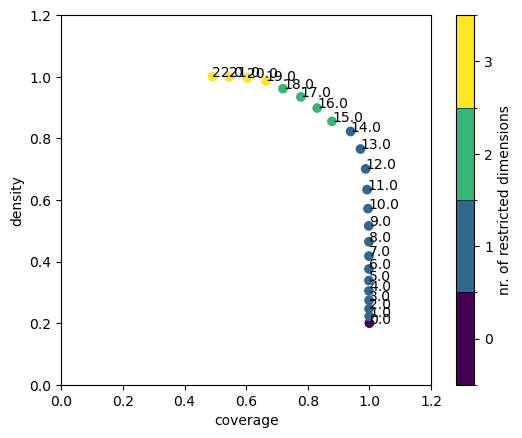

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

In [7]:
data = all_outcomes_dic['Overall Deaths']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

# Perform PRIM analysis
prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box_deaths_nat = prim_alg.find_box()

# Show tradeoff
box_deaths_nat.show_tradeoff(annotated=True)

# Plot results
plt.show()

# Extract the box's criteria directly from box_lims attribute
box_criteria = box_deaths_nat.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_deaths.csv', index=False)

coverage       0.939000
density        0.822242
id            14.000000
k           1878.000000
mass           0.228400
mean           0.822242
n           2284.000000
res_dim        1.000000
Name: 14, dtype: float64

            box 14                            
               min       max qp value qp value
A.3_pfail  0.00006  0.228415      NaN      0.0



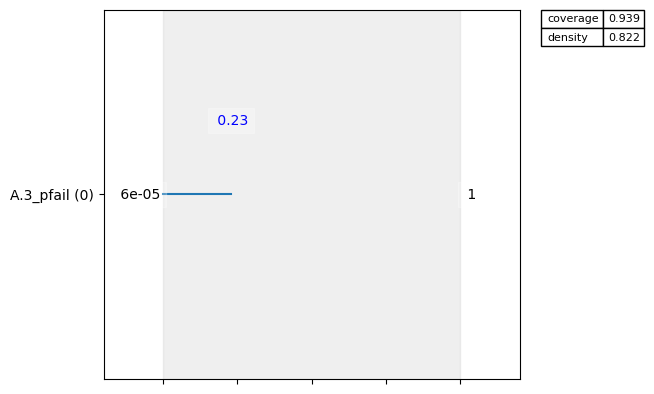

In [8]:
# Look at box 14 because it has only 1 dimension and is above 0.8 density
point = 14
box_deaths_nat.inspect(point)
box_deaths_nat.inspect(point,style='graph')
plt.show()

## Dimensional Stacking

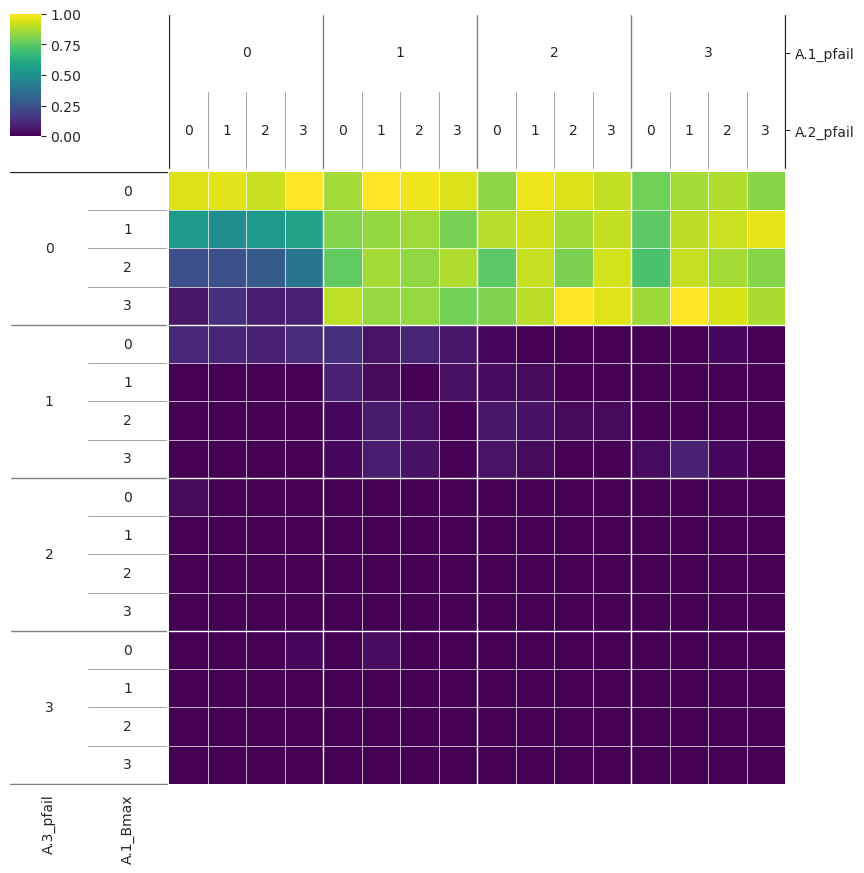

In [9]:
# Do dimensional stacking of results deaths
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(cleaned_experiments, y, 2, nbins=4)
plt.show()

## Expected annual damage

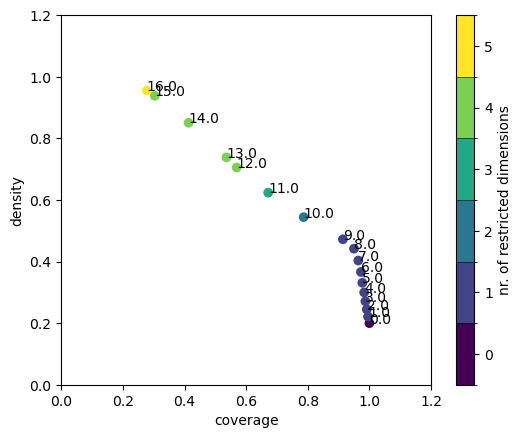

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

In [10]:
data = all_outcomes_dic['Overall Damage']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

# Perform PRIM analysis
prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da = prim_alg.find_box()

# Show tradeoff
box1da.show_tradeoff(annotated=True)

# Plot results
plt.show()

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_damage.csv', index=False)

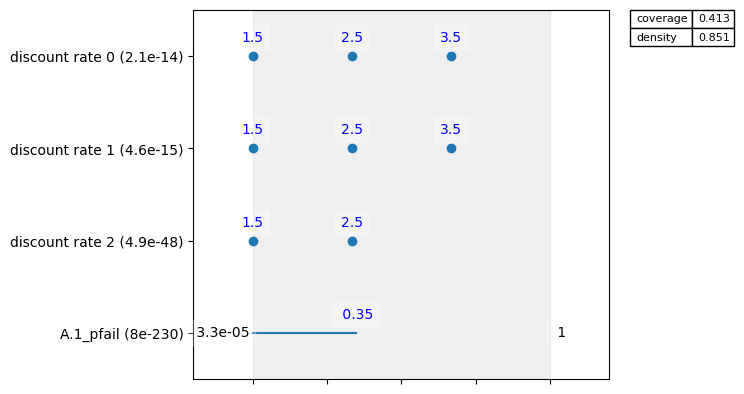

In [11]:
# Again we will look at box 14 
point = 14
box1da.inspect(point,style='graph')
plt.show()

In [12]:
box1da.resample(point)

,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
discount rate 0,100.0,100.0
discount rate 1,100.0,100.0
discount rate 2,100.0,100.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0
A.2_pfail,0.0,0.0


The resampling shows that for the top 4 parameters we can exactly reproduce coverage and density. This confirms the suggestion of 4 dimensions. The other parameters can be safely ignored when interpreting the results.

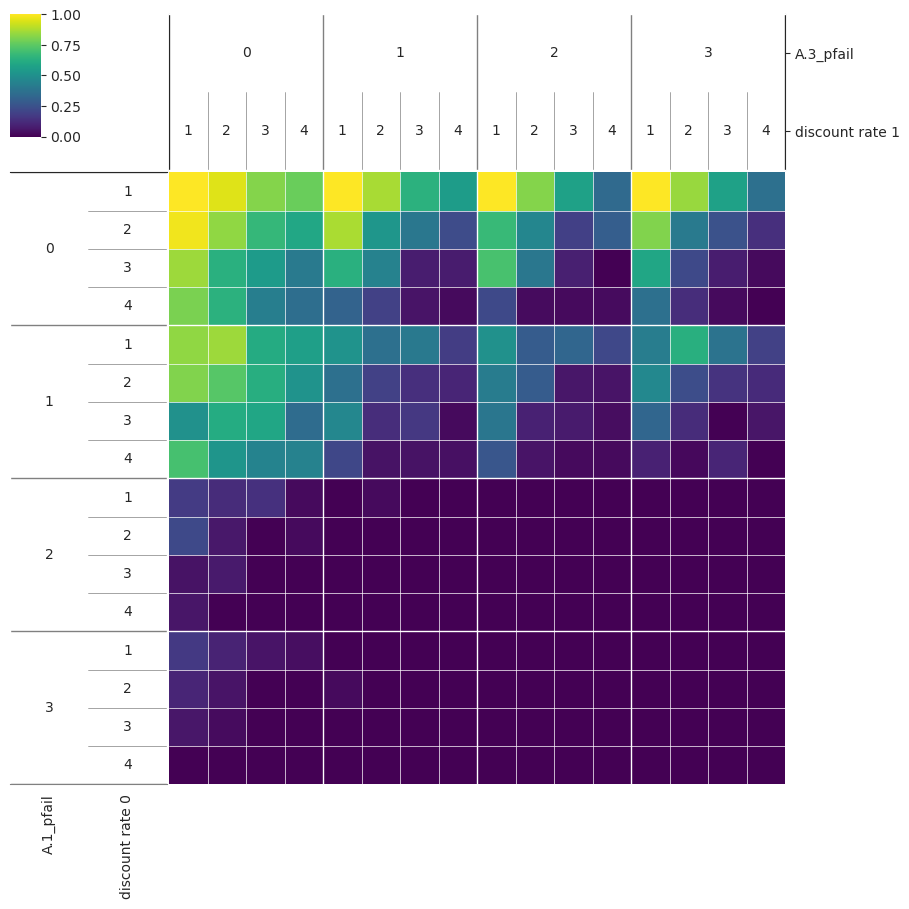

In [13]:
# Do dimensional stacking of results damage
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(cleaned_experiments, y, 2, nbins=4)
plt.show()

## Disaggregated Damage

For each dike ring:

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

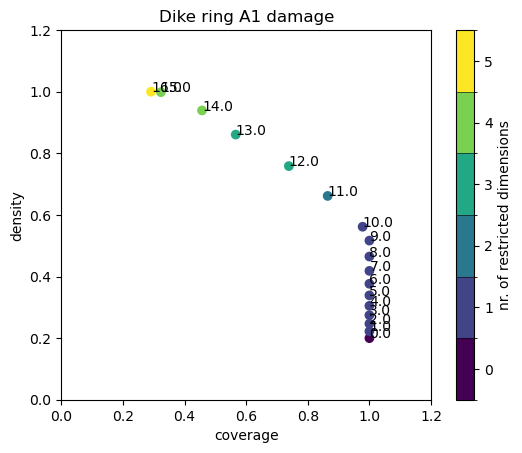

In [14]:
data = all_outcomes_dic['A.1_Expected Annual Damage']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A1 damage')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_damage_A1.csv', index=False)

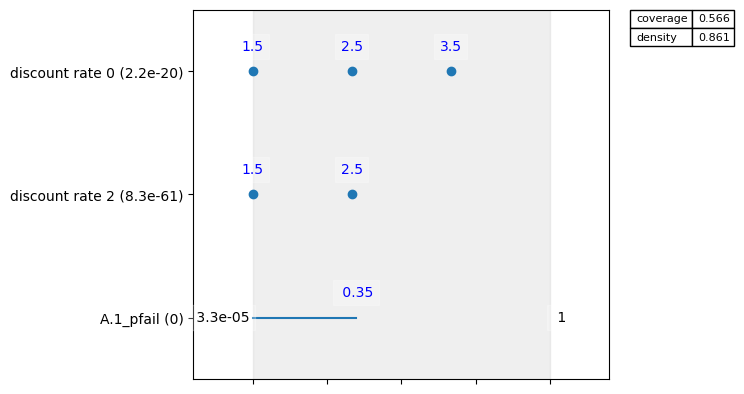

In [15]:
# Take box 13
point = 13
box1da1.inspect(point,style='graph')
plt.show()

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

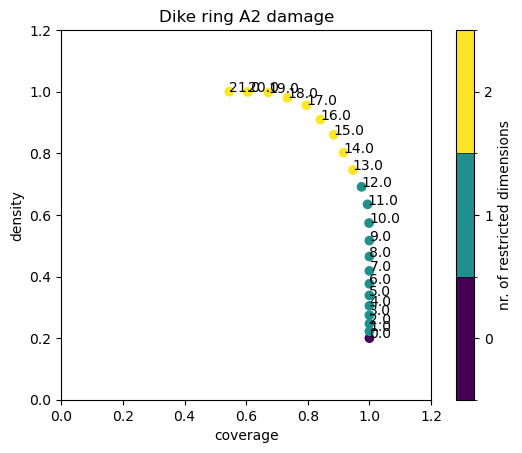

In [16]:
data = all_outcomes_dic['A.2_Expected Annual Damage']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A2 damage')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_damage_A2.csv', index=False)

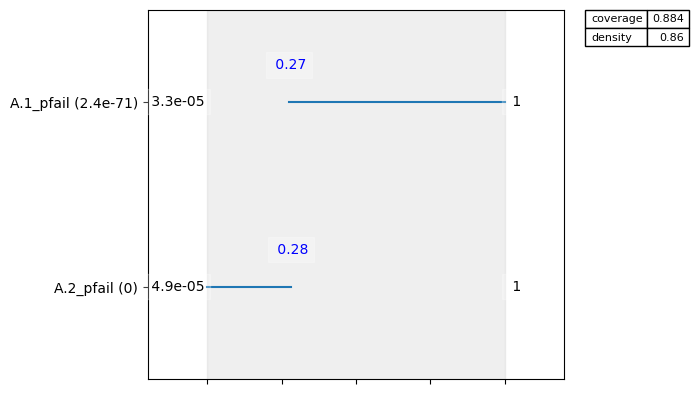

In [17]:
# Look at box 15
point = 15
box1da1.inspect(point,style='graph')
plt.show()

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

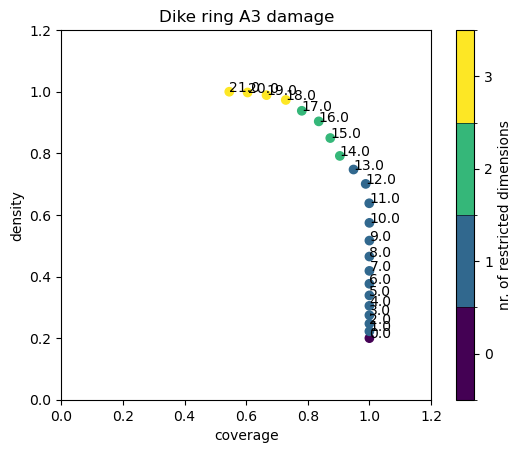

In [18]:
data = all_outcomes_dic['A.3_Expected Annual Damage']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A3 damage')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_damage_A3.csv', index=False)

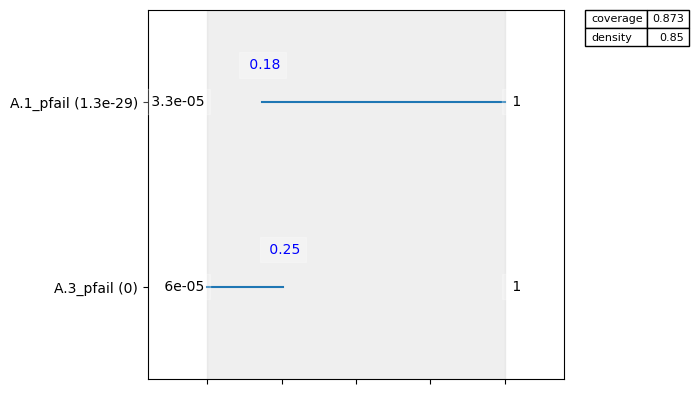

In [19]:
# Look at box 15
point = 15
box1da1.inspect(point,style='graph')
plt.show()

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

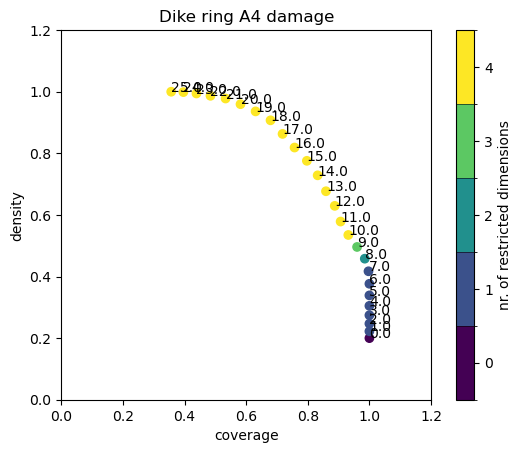

In [20]:
data = all_outcomes_dic['A.4_Expected Annual Damage']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A4 damage')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_damage_A4.csv', index=False)

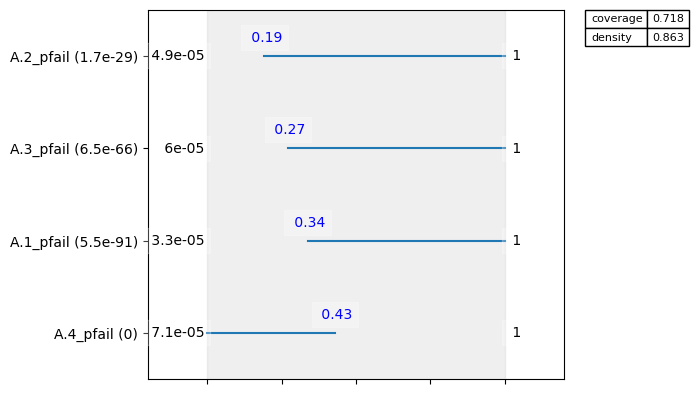

In [21]:
# Look at box 17
point = 17
box1da1.inspect(point,style='graph')
plt.show()

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

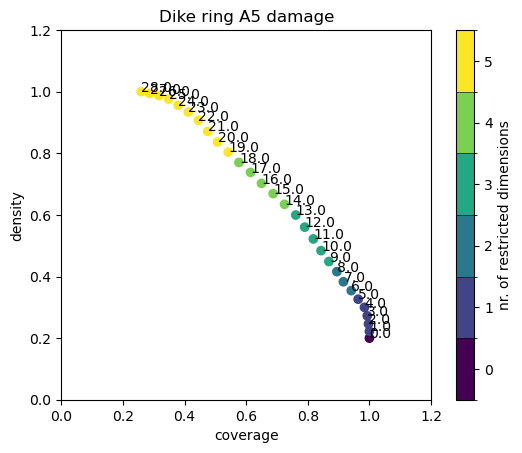

In [22]:
data = all_outcomes_dic['A.5_Expected Annual Damage']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A5 damage')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_damage_A5.csv', index=False)

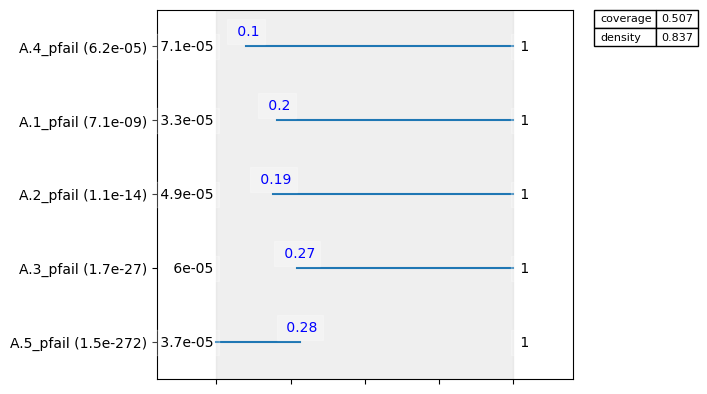

In [23]:
# Look at box 20
point = 20
box1da1.inspect(point,style='graph')
plt.show()

## Disaggregate deaths

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

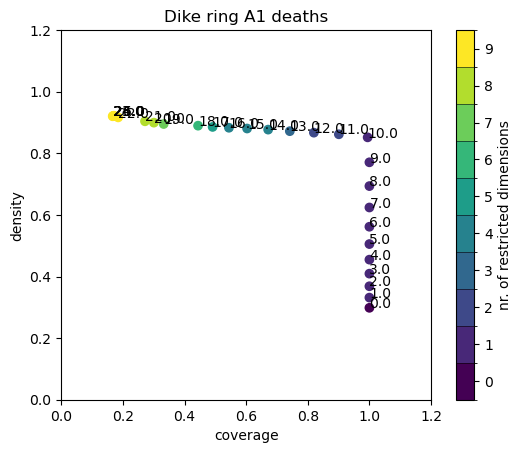

In [24]:
data = all_outcomes_dic['A.1_Expected Number of Deaths']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 70)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A1 deaths')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_deaths_A1.csv', index=False)

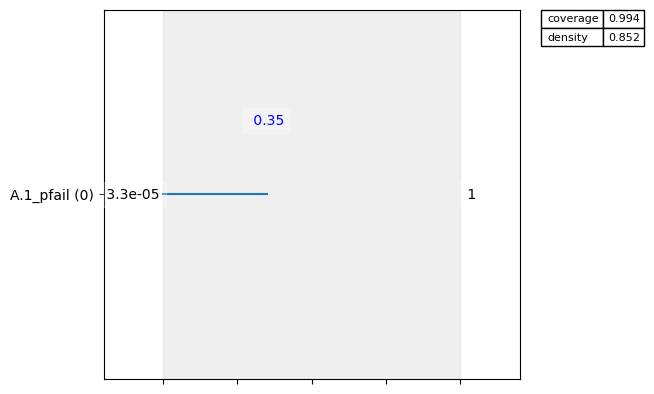

In [25]:
# Look at box 10
point = 10
box1da1.inspect(point,style='graph')
plt.show()

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

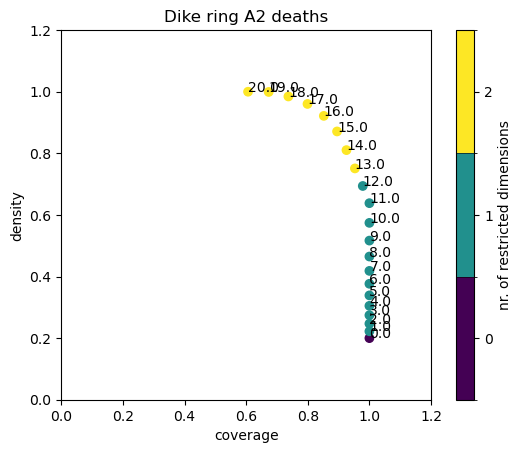

In [26]:
data = all_outcomes_dic['A.2_Expected Number of Deaths']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A2 deaths')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_deaths_A2.csv', index=False)

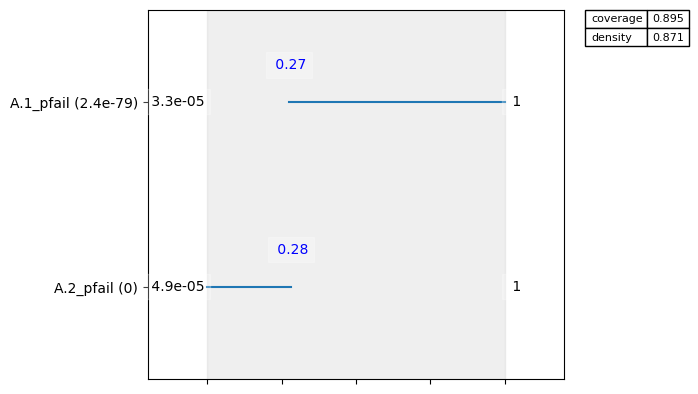

In [27]:
# Look at box 15
point = 15
box1da1.inspect(point,style='graph')
plt.show()

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

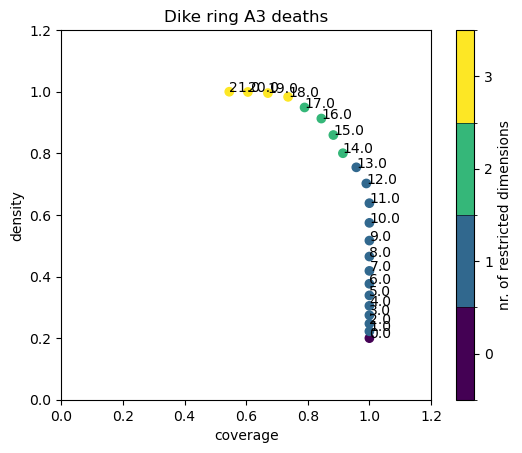

In [28]:
data = all_outcomes_dic['A.3_Expected Number of Deaths']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A3 deaths')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_deaths_A3.csv', index=False)

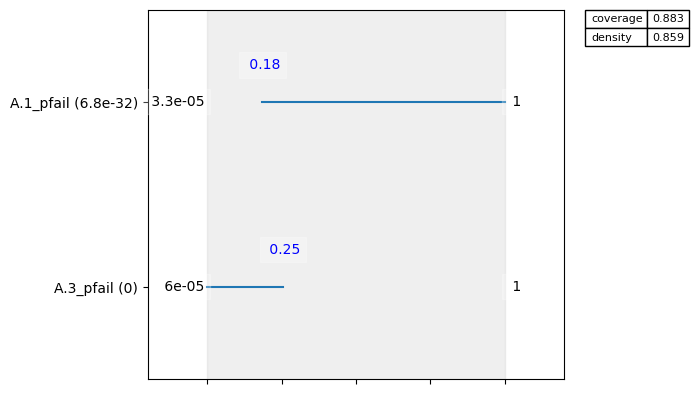

In [29]:
# Look at box 15
point = 15
box1da1.inspect(point,style='graph')
plt.show()

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

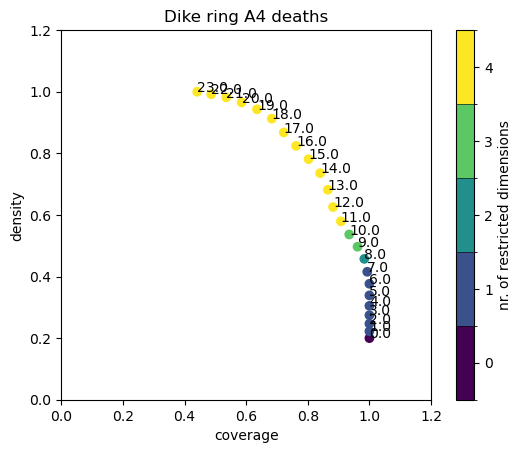

In [30]:
data = all_outcomes_dic['A.4_Expected Number of Deaths']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A4 deaths')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_deaths_A4.csv', index=False)

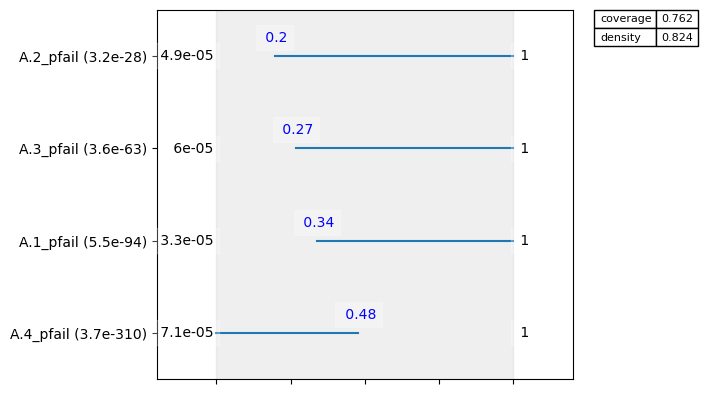

In [31]:
# Look at box 16
point = 16
box1da1.inspect(point,style='graph')
plt.show()

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.002793  {1.5, 10.0, 1.0}   0.000033   
1                      132  349.994978  {1.5, 10.0, 1.0}   0.999958   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.026305  {1.0, 10.0, 1.5}   0.000049   30.031605  {1.0, 10.0, 1.5}   
1  349.968349  {1.0, 10.0, 1.5}   0.999911  349.979725  {1.0, 10.0, 1.5}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000060   30.014574  {1.5, 10.0, 1.0}   0.000071   30.025937   
1   0.999901  349.982768  {1.5, 10.0, 1.0}   0.999909  349.988550   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000037  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999915  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

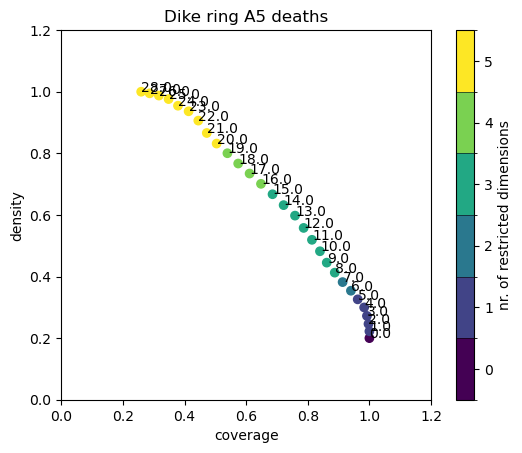

In [32]:
data = all_outcomes_dic['A.5_Expected Number of Deaths']

# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8, peel_alpha=0.1, mode=RuleInductionType.REGRESSION)
box1da1 = prim_alg.find_box()
box1da1.show_tradeoff(annotated=True)
plt.title('Dike ring A5 deaths')

# Extract the box's criteria directly from box_lims attribute
box_criteria = box1da1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('data/experiments_in_box_deaths_A5.csv', index=False)

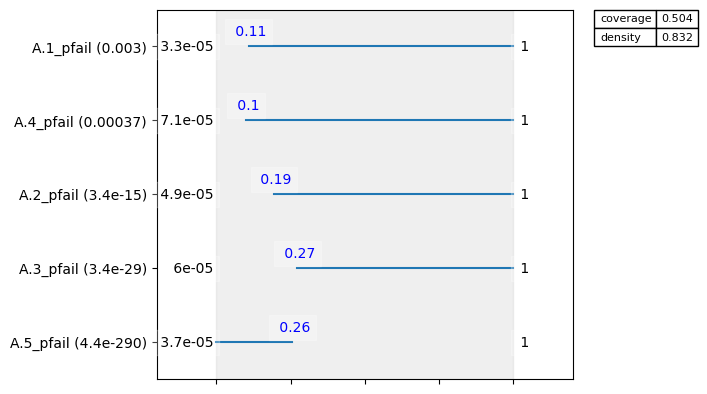

In [33]:
# Look at box 20
point = 20
box1da1.inspect(point,style='graph')
plt.show()

## Merge all regional outcomes together

In [36]:
import glob
# List of CSV files to merge
file_pattern = 'data/experiments_in_box_*_A*.csv'
file_list = glob.glob(file_pattern)

# Initialize an empty list to hold all DataFrames
dfs = []

# Read each CSV file and append its DataFrame to the list
for file in file_list:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Optionally, save the merged DataFrame to a new CSV file
merged_output_file = 'data/merged_experiments.csv'
merged_df.to_csv(merged_output_file, index=False)